 <img src="images/jon-tyson-A-obUh61bKw-unsplash.jpg" width="600" height="340">

# Microsoft Movie Analysis

**Author:** Volha Puzikava
***

## Overview

This project analyzes the movie datasets from famous movie websites in order to find out what types of films have been doing the best at the box offices since 2010. The results of the exploratory data analyses can help the stakeholders in building a new movie studio, as they generate the insights of the top genres and directors with the highest average worldwide gross, as well as cover the relation between the movie ratings and production budget.

## Business Problem

Microsoft have decided to create a new movie studio, but they don’t know anything about creating movies. My task was to analyze three movie datasets from [IMDB](https://www.imdb.com), [TheMovieDB](https://www.themoviedb.org) and [The Numbers](https://www.the-numbers.com) and yeild three business recommendations for the company.

***
Questions that were answered in the project:
* What are the highest worldwide grossing movie genres since 2010?
* What are the highest worldwide grossing movie directors since 2010?
* Is there a relation between average movie ratings and the production budget? If yes, recommend the production budget with the highest rating.
***

## Data Understanding

The data for the analysis was collected from various locations. Some data files were compressed CSV, while the data from IMDB was located in a SQLite database. The data provided various information about movies: their own specific id, genre, release date, original title, production budget, language, directors, writers, etc. The metric information was represented by rating and worldwide gross. The movie aspects that were analyzed in terms of metrics included genres, directors and production budget.
***
Since different dataframes contained different release years (some went back to 1916), I decided to perform analysis on movies that were released starting 2010. As a result, the movie analyses were peformed on the eight-year period: from 2010 to 2018. Also, because some movies didn't belong to one particular genre, but to many, in order to find out the top worldwide grossing genres I had to assign those movies to multiple genres thus duplicating thier worldwide gross.
***

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Retrieve data
df1 = pd.read_csv('zippedData/tmdb.movies.csv.gz')
display(df1.head())
df2 = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
df2.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [3]:
# Open the connection to database
import sqlite3
conn = sqlite3.connect('zippedData/im.db')
cur = conn.cursor()
# Execute the query
cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""")
# Fetch the result and store it in table_names
table_names = cur.fetchall()
table_names

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

In [4]:
# Select specific columns and wrap the results into Pandas DataFrame
p = """
SELECT mb.primary_title AS movie, 
       mb.genres AS genre, 
       mb.start_year AS year, 
       mr.averagerating AS rating, 
       p.primary_name AS director
FROM movie_basics AS mb
JOIN movie_ratings AS mr
    USING(movie_id)
JOIN directors as d
    USING(movie_id)
JOIN persons AS p
    USING(person_id)
ORDER BY start_year DESC;
"""
df3 = pd.read_sql(p, conn)
df3.head()

,movie,genre,year,rating,director
0,One Day Before the Rainy Season,"Biography,Drama",2019,7.2,Mani Kaul
1,On kadin,Drama,2019,7.1,Serif Gören
2,Abolição,Documentary,2019,7.4,Zózimo Bulbul
3,Alita: Battle Angel,"Action,Adventure,Sci-Fi",2019,7.5,Robert Rodriguez
4,Alita: Battle Angel,"Action,Adventure,Sci-Fi",2019,7.5,Robert Rodriguez


## Data Preparation

Only one out of the three DataFrames contained duplicates and null values. Duplicates were dropped and null values were changed to 'Unknown'. The date columns in the provided DataFrames were of a different format, so they were transformed only to show the year of release. The type of those columns was also changed from object to integer. Since almost all the movies belonged to different genres rather than just to one, the data was exploded in order to transform each element in the column 'genre' to a separate row. The columns of the DataFrames, that contained the same information, were renamed so the DataFrames could be merged on the same column names.

***


In [5]:
# Get a concise summary of the dataframes
display(df1.info())
display(df2.info())
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181387 entries, 0 to 181386
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   movie     181387 non-null  object 
 1   genre     180047 non-null  object 
 2   year      181387 non-null  int64  
 3   rating    181387 non-null  float64
 4   director  181387 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 6.9+ MB


I started working with Dataframe from [TheMovieDB](https://www.themoviedb.org) website. First, I selected the columns I was interested in, converted the date format and picked only the movies with the release date 2010 and up.

In [6]:
# Select the necessary DataFrame information
df1 = df1.loc[:, ['release_date', 'title', 'vote_average']]
# Select only a year from the release_date column and sort the results in the descending order
df1['release_date'] = df1.release_date.map(lambda x: x[:4])
df1 = df1.sort_values('release_date', ascending = False)
df1.head()

,release_date,title,vote_average
26057,2020,Murdery Christmas,0.0
24384,2019,Piercing,5.9
25429,2019,Bilby,5.0
24933,2019,Late Afternoon,7.7
24764,2019,Holiday,5.5


In [7]:
# Convert the release_date column into an integer type
df1['release_date'] = df1['release_date'].astype(str).astype(int)
# Select all movies that were released starting 2010
df1 = df1[(df1['release_date'] >= 2010)]
df1.tail()

,release_date,title,vote_average
1675,2010,No Fun City,4.3
1729,2010,Mountains That Take Wing: Angela Davis & Yuri ...,6.0
1731,2010,Unrequited Love,6.0
1640,2010,Deuce of Spades,5.3
1730,2010,Works of Art,6.0


The next DataFrame for analysis was taken from [The Numbers](https://www.the-numbers.com) website. The performed manipulations were the same as before: select the columns of interest, overwrite and convert the date format and choose the years for the release date 2010 and up.

In [8]:
# Select the necessary DataFrame information
df2 = df2.loc[:, ['release_date', 'movie', 'production_budget', 'worldwide_gross']]
#Select only a year from the release_date column and sort the results in the descending order
df2['release_date'] = df2.release_date.map(lambda x: x[7:])
df2 = df2.sort_values('release_date', ascending = False)
df2.head()

,release_date,movie,production_budget,worldwide_gross
3633,2019,The Best of Enemies,"$10,000,000","$10,205,616"
3915,2019,El Chicano,"$8,000,000","$700,261"
580,2019,The Secret Life of Pets 2,"$80,000,000","$113,351,496"
496,2019,Shazam!,"$85,000,000","$362,899,733"
95,2019,Captain Marvel,"$175,000,000","$1,123,061,550"


In [9]:
# Change release_date column type into integer
df2['release_date'] = df2['release_date'].astype(str).astype(int)
# Select all movies that were released starting 2010
df2 = df2[df2['release_date'] >= 2010]
df2.tail()

,release_date,movie,production_budget,worldwide_gross
4572,2010,The Good Heart,"$3,800,000","$340,930"
2352,2010,Faster,"$24,000,000","$35,792,945"
5309,2010,Zombies of Mass Destruction,"$1,000,000",$0
3711,2010,Welcome to the Rileys,"$10,000,000","$355,919"
5564,2010,Anderson's Cross,"$300,000",$0


The data from [IMDB](https://www.imdb.com) website contained a lot of duplicates and null values. The duplicates were removed and the null values were changed to 'Unknown' in the genre column. The DataFrame was also exploded in order to transform each element of the genre column to a row.

In [10]:
# Check for duplicates in DataFrame3
duplicates = df3[df3.duplicated()]
duplicates

,movie,genre,year,rating,director
4,Alita: Battle Angel,"Action,Adventure,Sci-Fi",2019,7.5,Robert Rodriguez
5,Alita: Battle Angel,"Action,Adventure,Sci-Fi",2019,7.5,Robert Rodriguez
8,Shazam!,"Action,Adventure,Comedy",2019,7.4,David F. Sandberg
9,Shazam!,"Action,Adventure,Comedy",2019,7.4,David F. Sandberg
10,Shazam!,"Action,Adventure,Comedy",2019,7.4,David F. Sandberg
...,...,...,...,...,...
181372,Mago Digo Dai,Comedy,2010,7.2,Sri Lal Priyadeva
181380,Hatchet Sisters,Horror,2010,5.4,Jeremy Tidwell
181381,Hatchet Sisters,Horror,2010,5.4,Jeremy Tidwell
181383,Hatchet Sisters,Horror,2010,5.4,Joe Black


In [11]:
# Remove duplicates and recheck for duplicates
df3 = df3.drop_duplicates()
df3.duplicated().value_counts()

False    85949
dtype: int64

In [12]:
# Check for null values
df3.isna().sum()

movie         0
genre       798
year          0
rating        0
director      0
dtype: int64

In [13]:
# Change NaN values in a column to 'Unknown'
df3_filled = df3.fillna({'genre': 'Unknown'})
# Convert the elements in a column to a list and split the elements
df3['genre'] = df3_filled['genre'].tolist()
df3['genre'] = df3_filled['genre'].map(lambda x: x.split(','))
# Explode the DataFrame transforming each element from a list to a new row
df3.explode('genre')

,movie,genre,year,rating,director
0,One Day Before the Rainy Season,Biography,2019,7.2,Mani Kaul
0,One Day Before the Rainy Season,Drama,2019,7.2,Mani Kaul
1,On kadin,Drama,2019,7.1,Serif Gören
2,Abolição,Documentary,2019,7.4,Zózimo Bulbul
3,Alita: Battle Angel,Action,2019,7.5,Robert Rodriguez
...,...,...,...,...,...
181378,Setteekh,Thriller,2010,5.1,Evgeniy Pavlov
181379,Hatchet Sisters,Horror,2010,5.4,Jeremy Tidwell
181382,Hatchet Sisters,Horror,2010,5.4,Joe Black
181385,Peculiar Pets,Documentary,2010,6.4,Adrian Cale


The columns of the first two DataFrames were renamed and three DataFrames were merged.

In [14]:
# Rename the necessary columns 
df1_renamed = df1.rename(columns = {'title' : 'movie', 'release_date' : 'year', 'vote_average' : 'rating'})
display(df1_renamed.head())
df2_renamed = df2.rename(columns = {'release_date' : 'year'})
df2_renamed.head()

,year,movie,rating
26057,2020,Murdery Christmas,0.0
24384,2019,Piercing,5.9
25429,2019,Bilby,5.0
24933,2019,Late Afternoon,7.7
24764,2019,Holiday,5.5


,year,movie,production_budget,worldwide_gross
3633,2019,The Best of Enemies,"$10,000,000","$10,205,616"
3915,2019,El Chicano,"$8,000,000","$700,261"
580,2019,The Secret Life of Pets 2,"$80,000,000","$113,351,496"
496,2019,Shazam!,"$85,000,000","$362,899,733"
95,2019,Captain Marvel,"$175,000,000","$1,123,061,550"


In [15]:
# Merge all DataFrames into one on the columns with the same names
new_df = df3.merge(df1_renamed, on = ['year', 'movie', 'rating']).merge(df2_renamed, on = ['year', 'movie']).explode('genre')
new_df.head()

,movie,genre,year,rating,director,production_budget,worldwide_gross
0,Tomb Raider,Action,2018,6.3,Roar Uthaug,"$90,000,000","$273,477,501"
0,Tomb Raider,Adventure,2018,6.3,Roar Uthaug,"$90,000,000","$273,477,501"
0,Tomb Raider,Fantasy,2018,6.3,Roar Uthaug,"$90,000,000","$273,477,501"
1,Hell Fest,Horror,2018,5.5,Gregory Plotkin,"$5,500,000","$18,119,231"
2,The Sisters Brothers,Adventure,2018,7.0,Jacques Audiard,"$38,000,000","$13,143,056"


## Data Modeling
Horizontal bar charts were plotted in order to find the most wolrdwide grossing movie genres and movie directors since 2010. 
***
To determine the relation between the production budget and movie rating, the following steps were performed:
* the production budget was binned, however, the outlier (the movie with the highest production budget) was not included
* the data was grouped, the average rating was found for each binned category
* bar chart was plotted
***
All the information was taken from the merged DataFrame. 


To find the highest worldwide grossing movie genres since 2010:

In [16]:
# Select necessary columns
gross_genre = new_df[['genre', 'worldwide_gross']]
gross_genre.head()

,genre,worldwide_gross
0,Action,"$273,477,501"
0,Adventure,"$273,477,501"
0,Fantasy,"$273,477,501"
1,Horror,"$18,119,231"
2,Adventure,"$13,143,056"


In [17]:
# Change worldwide_gross column type to integer 
gross_genre["worldwide_gross"] = gross_genre["worldwide_gross"].replace("[$,]", "", regex=True).astype(int)
# Group the data according to the necessary category, find the average gross, sort in the ascending order
gross_genre_new = gross_genre.groupby(['genre'])['worldwide_gross'].mean().sort_values(ascending = True)
gross_genre_new

<ipython-input-17-82aa84cc924b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gross_genre["worldwide_gross"] = gross_genre["worldwide_gross"].replace("[$,]", "", regex=True).astype(int)


genre
Documentary    7.712436e+06
Music          9.124764e+06
War            4.340352e+07
Sport          4.835648e+07
Romance        6.490569e+07
Crime          7.799637e+07
Drama          7.987591e+07
Horror         8.173075e+07
Biography      8.386885e+07
Thriller       9.185368e+07
Mystery        9.507077e+07
History        1.261628e+08
Family         1.879096e+08
Comedy         1.931360e+08
Action         2.607188e+08
Fantasy        2.690376e+08
Sci-Fi         3.136402e+08
Adventure      3.945403e+08
Animation      5.785690e+08
Name: worldwide_gross, dtype: float64

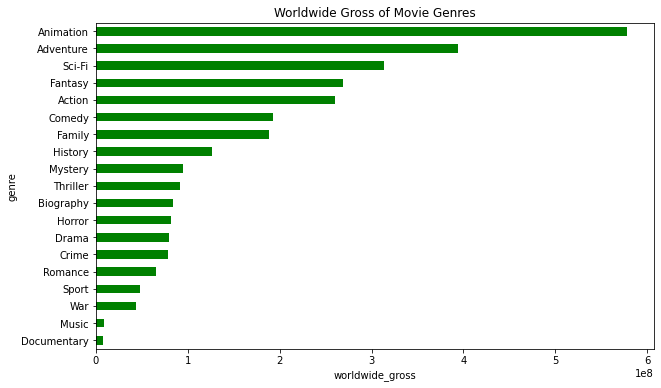

In [18]:
# Plot the graph
g = gross_genre_new.plot(kind = 'barh', figsize = (10,6), title = "Worldwide Gross of Movie Genres", color = 'green')
g.set_xlabel('worldwide_gross')
g.figure.savefig('gross-genre')

According to the plotted bar chart, the highest worldwide grossing movie genres since 2010 have been animation, adventure and science fiction.

To find the highest worldwide grossing movie directors since 2010:

In [19]:
# Select necessary information from DataFrame
gross_director = new_df[['worldwide_gross', 'director']]
gross_director.head()

,worldwide_gross,director
0,"$273,477,501",Roar Uthaug
0,"$273,477,501",Roar Uthaug
0,"$273,477,501",Roar Uthaug
1,"$18,119,231",Gregory Plotkin
2,"$13,143,056",Jacques Audiard


In [20]:
# Change worldwide_gross column type to integer
gross_director["worldwide_gross"] = gross_director["worldwide_gross"].replace("[$,]", "", regex=True).astype(int)
# Group the data according to the necessary category, find the average gross, sort in the ascending order
gross_director_new = gross_director.groupby(['director'])['worldwide_gross'].mean().sort_values(ascending = True)
gross_director_new

<ipython-input-20-0a74003bec2d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gross_director["worldwide_gross"] = gross_director["worldwide_gross"].replace("[$,]", "", regex=True).astype(int)


director
Aaron T. Wells     0.000000e+00
David Hackl        0.000000e+00
Michael Winnick    0.000000e+00
Christian Sesma    0.000000e+00
Benni Diez         0.000000e+00
                       ...     
Joachim Rønning    7.882411e+08
Eric Guillon       1.034728e+09
Pierre Coffin      1.097532e+09
Kyle Balda         1.097532e+09
Joss Whedon        1.403014e+09
Name: worldwide_gross, Length: 142, dtype: float64

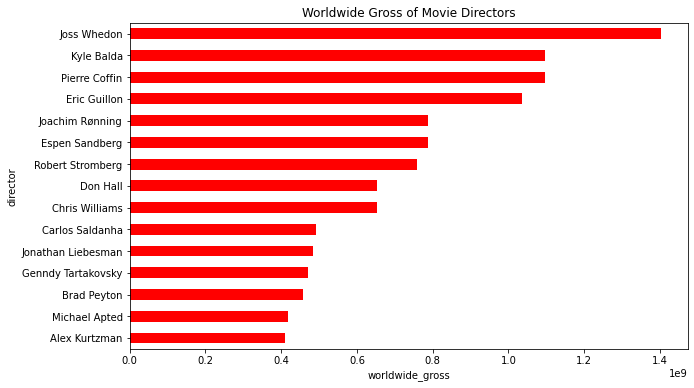

In [21]:
# Plot the graph, include the top 15 directors
gd = gross_director_new[-15:].plot(kind = 'barh', figsize = (10,6), title = "Worldwide Gross of Movie Directors", color = 'red')
gd.set_xlabel('worldwide_gross')
gd.figure.savefig('gross-director')

The resulted bar chart represents fifteen highest worldwide grossing movie directors since 2010. The first three places belong to [Joss Whedon](https://www.imdb.com/name/nm0923736/#director), [Kyle Balda](https://www.imdb.com/name/nm0049633/), and [Pierre Coffin](https://www.imdb.com/name/nm1853544/).

To find the relation between average movie ratings and the production budget:

In [22]:
# Select necessary information from DataFrame
rating_budget = new_df[['rating', 'production_budget']]
rating_budget.head()

,rating,production_budget
0,6.3,"$90,000,000"
0,6.3,"$90,000,000"
0,6.3,"$90,000,000"
1,5.5,"$5,500,000"
2,7.0,"$38,000,000"


In [23]:
# Change production_budget column type to integer
rating_budget["production_budget"] = rating_budget["production_budget"].replace("[$,]", "", regex=True).astype(int)
# Bin production_budget
binned_budget = rating_budget.groupby(['rating'])['production_budget'].transform(pd.cut, bins=[0, 50000000, 100000000, 150000000, 200000000, 250000000, 300000000], precision=0, right=False)
binned_budget

<ipython-input-23-c6ca34f979bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_budget["production_budget"] = rating_budget["production_budget"].replace("[$,]", "", regex=True).astype(int)


0      [50000000, 100000000)
0      [50000000, 100000000)
0      [50000000, 100000000)
1              [0, 50000000)
2              [0, 50000000)
               ...          
161            [0, 50000000)
162            [0, 50000000)
162            [0, 50000000)
163            [0, 50000000)
164            [0, 50000000)
Name: production_budget, Length: 414, dtype: category
Categories (6, interval[int64]): [[0, 50000000) < [50000000, 100000000) < [100000000, 150000000) < [150000000, 200000000) < [200000000, 250000000) < [250000000, 300000000)]

In [24]:
# Group the data, find the average movie rating for binned_budget
qd = rating_budget.groupby([binned_budget])[['rating']].mean()
qd

,rating
production_budget,
"[0, 50000000)",6.234221
"[50000000, 100000000)",6.267143
"[100000000, 150000000)",6.150000
"[150000000, 200000000)",6.700000
"[200000000, 250000000)",6.600000
"[250000000, 300000000)",NaN


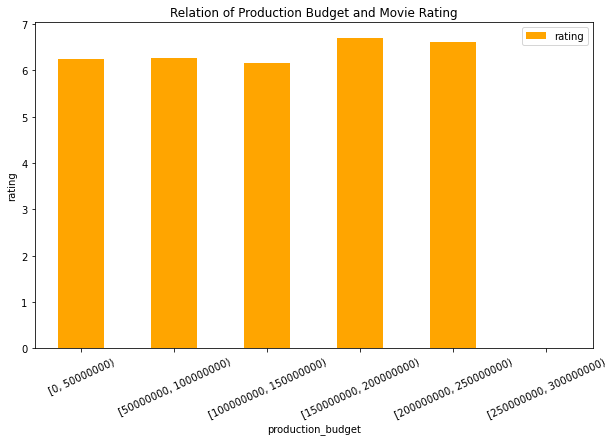

In [25]:
# Plot the graph
qd.plot(kind = 'bar', figsize = (10,6), title = "Relation of Production Budget and Movie Rating", color = 'orange')
plt.ylabel('rating')
plt.xticks(rotation = 25)
plt.savefig('Budget-rating')

As seen from the bar plot, the production budget doesn't influcence much on the average movie rating, since the ratings are between 6 and 7 stars for all budgets. However, the best ratings belong to the movies with the production budget from 150 million dollars to 200 million dollars.

## Conclusions
This analysis leads to three recommendations for building a new movie studio by Microsoft:

***
* The movie genres with the highest average worldwide gross are Animation, Adventure and Science Fiction.
* The movie directors with the highest average worldwide gross are Joss Whedon, Kyle Balda, and Pierre Coffin.
* There is no direct relation between movie production budget and its rating, since average rating fluctuates between 6 and 7 stars. However, the best ratings belongs to movie with the production budget from 150 million dollars to 200 million dollars.
***
The results of the performed analysis can be used by Microsoft in order to get the higher profit when filming. However, a deeper research can be conducted. So, the analysis of movie ratings and the months when the movies were released, the wolrdwide gross of the movies and the writers of those movies, etc. can be done in order to get a bigger image of the movies that do the best at the box offices. Also, as concerns the relation between production budget and average movie ratings, more research could be conducted and the number of films in each category should be taken into account. If we look at the number of movies for each binned category, we will see that the majority of movies have budget below 50 million dollars and their ratings fluctuate from the lowest to the highest. So, to my opinion, movies in those category along should be analyzed to get the more accurate image of the situation.